# IBM Quantum Hackathon 
July 6, 2022

## Team 2
Rajas Chari, Aramide Moronfoye, Yuchen Pang, Emily Waite

In [13]:
# References:
# https://arxiv.org/abs/2007.14044
# https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html
# https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

import itertools
import numpy as np
import scipy
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient


from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.utils.loss_functions import Loss
from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42
rng = algorithm_globals.random

The quantum instance here is where we specify where the quantum algorthim will run. In this case, we use the simulator Aer, which is part of Qiskit. 

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

Here we import the iris data set and set up the training and testing sub-sets. For our training, we used 60% of the data set (which consists of 150 flowers, 50 of each type) and then used the remaining 40% of our data set to test the algorithm.

In [3]:
# load data

from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data, iris.target
y = np.eye(4)[y] # one-hot encoding

n_train = int(0.6 * len(X)) 
perm = rng.permutation(len(X))
X, y = X[perm], y[perm]
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

# preprocess
epsilon = 1e-16
alpha = 0.005
p = scipy.stats.norm.ppf(1-epsilon**(1/X.shape[1])/2)

X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

def preprocess(X):
    X = (X-X_train_mean)/X_train_std
    if np.any(np.abs(X) > p):
        assert False, f"Some features ({np.sum(np.abs(X)>p)}) are too large. Try reducing epsilon."
    return X/p*np.pi*(1-alpha/2)

X = preprocess(X)
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Baseline

Here we test what we will refer to as a baseline. The omega values and circuit configuration we use here are the ones given by Cappelletti <i>et al.</i>. This also uses the built-in squared loss function. For each implimentation, we run the simulator 5 times and average the test score over all 5 times. For this, you can see that the average test score was #### , which took #### iterations to get to.

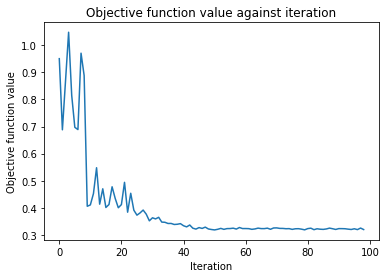

Average test score: 0.8033333333333335
Average num of iterations: 110.8


In [4]:
# construct the circuit
test_average = 0
iter_average = 0
for i in range(5):
    omegas = [Parameter(f'omega_{i}') for i in range(4)]
    thetas = [Parameter(f'theta_{i}') for i in range(8)]

    layers = [
        (omegas[0], omegas[1]),
        (thetas[0], thetas[1]),
        (omegas[2], omegas[3]),
        (thetas[2], thetas[3]),
        (omegas[0], omegas[1]),
        (thetas[4], thetas[5]),
        (omegas[2], omegas[3]),
        (thetas[6], thetas[7])]

    qc = QuantumCircuit(2)
    for i, (a, b) in enumerate(layers):
        qc.rx(np.pi/2, 0); qc.rz(a, 0); qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1); qc.rz(b, 1); qc.rx(np.pi/2, 1)
        if i < len(layers) - 1:
            qc.cz(0, 1)

    qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

    circuit_classifier = NeuralNetworkClassifier(
        neural_network=qc_nn, loss='squared_error', one_hot=True, optimizer=COBYLA(), callback=callback_graph,)
    
    objective_func_vals = []
    circuit_classifier.fit(X_train, y_train)
    test_average += circuit_classifier.score(X_test, y_test)
    iter_average += len(objective_func_vals)

print("Average test score: "+str(test_average/5.0))
print("Average num of iterations: "+str(iter_average/5.0))

## Attempt #1: Changing the Characteristics used

We note that the baseline only uses two pairs of data: the sepal width + sepal length and the petal length + petal width. However, based on the data (see <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set#/media/File:Iris_dataset_scatterplot.svg">this image</a>), sepal width + sepal length are not very strong defining features of all three types of Iris. To correct for this, we used several different layer schemes to determine if this could improve the performance of algorithm. We do reckognize that the use of more pairings of $\omega_i$ increases the number of qbits necessary, so while this does increase the accuracy, it also increases the cost. 
<p></p>
As we can see, using 8 layers but selecting different characteristics gave an average of ####, compared to the baseline of ####, so this is a substansial improvement. We further improved upon this by adding more layers, so that we could use all 6 different pairings of data, which gave the best result, with a test score averaging at ####. However, this also took the highest number of iterations and required the largest quantum computer, so this result does have its drawbacks. 

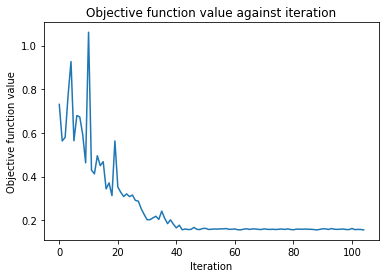

Average test score: 0.8433333333333334
Average num of iterations: 118.0


In [5]:
test_average = 0
iter_average = 0
for i in range(5):
    omegas = [Parameter(f'omega_{i}') for i in range(4)]
    thetas = [Parameter(f'theta_{i}') for i in range(8)]

    layers = [
        (omegas[2], omegas[3]),
        (thetas[0], thetas[1]),
        (omegas[0], omegas[2]),
        (thetas[2], thetas[3]),
        (omegas[2], omegas[3]),
        (thetas[4], thetas[5]),
        (omegas[1], omegas[3]),
        (thetas[6], thetas[7])] 

    qc = QuantumCircuit(2)
    for i, (a, b) in enumerate(layers):
        qc.rx(np.pi/2, 0); qc.rz(a, 0); qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1); qc.rz(b, 1); qc.rx(np.pi/2, 1)
        if i < len(layers) - 1:
            qc.cz(0, 1)

    qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

    circuit_classifier = NeuralNetworkClassifier(
        neural_network=qc_nn, loss='squared_error', one_hot=True, optimizer=COBYLA(), callback=callback_graph,)

    objective_func_vals = []
    circuit_classifier.fit(X_train, y_train)
    test_average += circuit_classifier.score(X_test, y_test)
    iter_average += len(objective_func_vals)
    
print("Average test score: "+str(test_average/5.0))
print("Average num of iterations: "+str(iter_average/5.0))

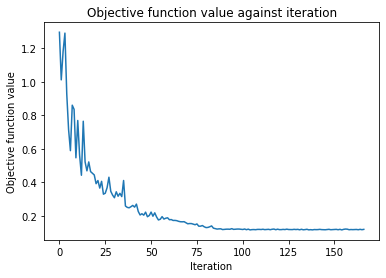

Average test score: 0.9666666666666666
Average num of iterations: 158.2


In [17]:
test_average = 0
iter_average = 0
for i in range(5):
    omegas = [Parameter(f'omega_{i}') for i in range(4)]
    thetas = [Parameter(f'theta_{i}') for i in range(12)]

    layers = [
        (omegas[0], omegas[2]),
        (thetas[0], thetas[1]),
        (omegas[0], omegas[3]),
        (thetas[2], thetas[3]),
        (omegas[2], omegas[3]),
        (thetas[4], thetas[5]),
        (omegas[1], omegas[2]),
        (thetas[6], thetas[7]),
        (omegas[1], omegas[3]),
        (thetas[8], thetas[9]),
        (omegas[2], omegas[3]),
        (thetas[10],thetas[11])]

    qc = QuantumCircuit(2)
    for i, (a, b) in enumerate(layers):
        qc.rx(np.pi/2, 0); qc.rz(a, 0); qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1); qc.rz(b, 1); qc.rx(np.pi/2, 1)
        if i < len(layers) - 1:
            qc.cz(0, 1)

    qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

    circuit_classifier = NeuralNetworkClassifier(
        neural_network=qc_nn, loss='squared_error', one_hot=True, optimizer=COBYLA(), callback=callback_graph,)

    objective_func_vals = []
    circuit_classifier.fit(X_train, y_train)
    test_average += circuit_classifier.score(X_test, y_test)
    iter_average += len(objective_func_vals)
    
print("Average test score: "+str(test_average/5.0))
print("Average num of iterations: "+str(iter_average/5.0))

The following was used to compare to the second version of Attempt 1, which uses a 12 layer scheme but uses the same pattern of alternating pairs of $\omega_0, \omega_1$ and $\omega_2, \omega_3$ to ensure that the characterstic selection and not the number of layers led to the improvement we saw. 

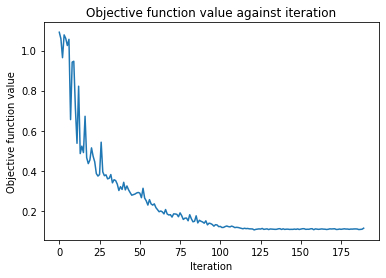

Average test score: 0.7066666666666667
Average num of iterations: 153.2


In [9]:
test_average = 0
iter_average = 0
for i in range(5):
    omegas = [Parameter(f'omega_{i}') for i in range(4)]
    thetas = [Parameter(f'theta_{i}') for i in range(12)]

    layers = [
        (omegas[0], omegas[1]),
        (thetas[0], thetas[1]),
        (omegas[2], omegas[3]),
        (thetas[2], thetas[3]),
        (omegas[0], omegas[1]),
        (thetas[4], thetas[5]),
        (omegas[2], omegas[3]),
        (thetas[6], thetas[7]),
        (omegas[0], omegas[1]),
        (thetas[8], thetas[9]),
        (omegas[2], omegas[3]),
        (thetas[10],thetas[11])] 

    qc = QuantumCircuit(2)
    for i, (a, b) in enumerate(layers):
        qc.rx(np.pi/2, 0); qc.rz(a, 0); qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1); qc.rz(b, 1); qc.rx(np.pi/2, 1)
        if i < len(layers) - 1:
            qc.cz(0, 1)

    qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

    circuit_classifier = NeuralNetworkClassifier(
        neural_network=qc_nn, loss='squared_error', one_hot=True, optimizer=COBYLA(), callback=callback_graph,)

    objective_func_vals = []
    circuit_classifier.fit(X_train, y_train)
    test_average += circuit_classifier.score(X_test, y_test)
    iter_average += len(objective_func_vals)
    
print("Average test score: "+str(test_average/5.0))
print("Average num of iterations: "+str(iter_average/5.0))

## Attempt #2: Editing the Loss Function

We note that we use the default Loss function, which is given by $\sum(predict_i - target_i) ^2$. However, we note that since the possible outputs are 00 (Iris setosa), 01 (Iris Versicolor), 10 (Iris Virginica), and 11 (not a flower!), we should make sure to bias against 11 since this is a nonsensical output. As a result, we added another term to the loss function, given by $\alpha N_{predict=11}$ We then varied $\alpha$ to see if this would improve the 

In [10]:
def modified_l2_loss(alpha):
    class ModifiedL2Loss(Loss):
        def evaluate(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
            self._validate_shapes(predict, target)

            bad_term = np.sum(predict[:,3])
            predict = predict[:,:3]
            predict /= np.sum(predict, axis=1).reshape(-1,1)
            target = target[:,:3]

            alpha = 0

            if len(predict.shape) <= 1:
                return (predict - target) ** 2 + alpha * bad_term
            else:
                return np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2 + alpha * bad_term

        def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
            return None
    
    return ModifiedL2Loss()


def modified_predict(circuit_classifier, X):
    forward = circuit_classifier._neural_network.forward(X, circuit_classifier._fit_result.x)
    predict_ = np.argmax(forward[:,:3], axis=1)
    predict = np.zeros(forward.shape)
    for i, v in enumerate(predict_):
        predict[i, v] = 1
    return predict

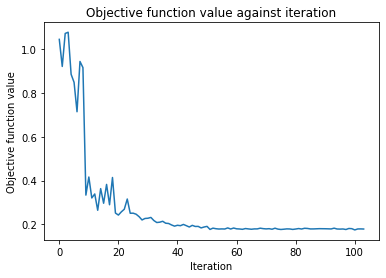

alpha=0.1
Average test score: 0.7833333333333334
Average num of iterations: 107.0
Modified predict score: 0.8466666666666667

[0.7933333333333332, 0.8100000000000002, 0.7833333333333334]
[0.8333333333333334, 0.8833333333333334, 0.8466666666666667]


In [22]:
scores = []
modified_scores = []

for alpha in [0.0, 0.01, 0.1]:
    test_average = 0
    iter_average = 0
    temp = 0
    for i in range(5):
        omegas = [Parameter(f'omega_{i}') for i in range(4)]
        thetas = [Parameter(f'theta_{i}') for i in range(8)]

        layers = [
            (omegas[0], omegas[1]),
            (thetas[0], thetas[1]),
            (omegas[2], omegas[3]),
            (thetas[2], thetas[3]),
            (omegas[0], omegas[1]),
            (thetas[4], thetas[5]),
            (omegas[2], omegas[3]),
            (thetas[6], thetas[7])] ### Average of 0.473, Used ~75 iterations###

        qc = QuantumCircuit(2)
        for i, (a, b) in enumerate(layers):
            qc.rx(np.pi/2, 0); qc.rz(a, 0); qc.rx(np.pi/2, 0)
            qc.rx(np.pi/2, 1); qc.rz(b, 1); qc.rx(np.pi/2, 1)
            if i < len(layers) - 1:
                qc.cz(0, 1)

        qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

        circuit_classifier = NeuralNetworkClassifier(
            neural_network=qc_nn, loss=modified_l2_loss(alpha), one_hot=True, optimizer=COBYLA(), callback=callback_graph,)

        objective_func_vals = []
        circuit_classifier.fit(X_train, y_train)
        test_average += circuit_classifier.score(X_test, y_test)
        iter_average += len(objective_func_vals)
        temp += sum(np.all(modified_predict(circuit_classifier, X_test) == y_test, axis=1))/len(y_test)
    
    scores.append(test_average/5.0)
    modified_scores.append(temp/5.0)
    print(f"alpha={alpha}")
    print("Average test score: "+str(test_average/5.0))
    print("Average num of iterations: "+str(iter_average/5.0))
    print("Modified predict score: "+str(temp/5.0))
    print()

print(scores)
print(modified_scores)

## Attempt #3

Besides considering ansatz circuit used in the original paper, we also try alternative circuit structures. Instead of using multiple simple layers, we construct a single-layer ansatz, where the input data are encoded as rotation angles around X and Z axes of the two qubits and then a general two-qubit gate described by 14 parameters are applied.

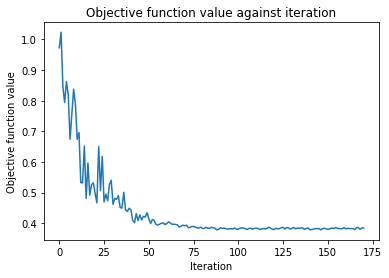

Average test score: 0.8366666666666667
Average num of iterations: 161.8


In [16]:
test_average = 0
iter_average = 0

for i in range(5):
    omegas = [Parameter(f'omega_{i}') for i in range(4)]
    thetas = [Parameter(f'theta_{i}') for i in range(14)]


    qc = QuantumCircuit(2)

    qc.u(np.pi/2, omegas[0], omegas[2], 0)
    qc.u(np.pi/2, omegas[1], omegas[3], 1)
    qc.barrier()
    qc.u(*thetas[0:3], 0)
    qc.u(*thetas[3:6], 1)
    qc.rz(np.pi/2, 1)
    qc.cx(1, 0)
    qc.rz(thetas[6], 0)
    qc.ry(thetas[7], 1)
    qc.cx(0, 1)
    qc.ry(thetas[8], 1)
    qc.cx(1, 0)
    qc.u(*thetas[8:11], 0)
    qc.u(*thetas[11:14], 1)

    qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

    circuit_classifier = NeuralNetworkClassifier(
        neural_network=qc_nn, loss='squared_error', one_hot=True, optimizer=COBYLA(), callback=callback_graph,)
    
    objective_func_vals = []
    circuit_classifier.fit(X_train, y_train)
    test_average += circuit_classifier.score(X_test, y_test)
    iter_average += len(objective_func_vals)

print("Average test score: "+str(test_average/5.0))
print("Average num of iterations: "+str(iter_average/5.0))

## Combining Together

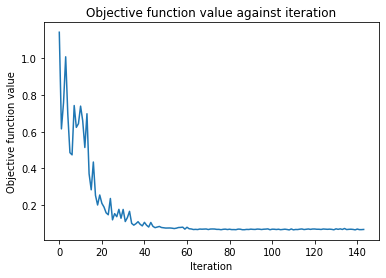

Average test score: 0.97
Average num of iterations: 138.6


In [23]:
test_average = 0
iter_average = 0
for i in range(5):
    omegas = [Parameter(f'omega_{i}') for i in range(4)]
    thetas = [Parameter(f'theta_{i}') for i in range(12)]

    layers = [
        (omegas[0], omegas[2]),
        (thetas[0], thetas[1]),
        (omegas[0], omegas[3]),
        (thetas[2], thetas[3]),
        (omegas[2], omegas[3]),
        (thetas[4], thetas[5]),
        (omegas[1], omegas[2]),
        (thetas[6], thetas[7]),
        (omegas[1], omegas[3]),
        (thetas[8], thetas[9]),
        (omegas[2], omegas[3]),
        (thetas[10],thetas[11])]

    qc = QuantumCircuit(2)
    for i, (a, b) in enumerate(layers):
        qc.rx(np.pi/2, 0); qc.rz(a, 0); qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1); qc.rz(b, 1); qc.rx(np.pi/2, 1)
        if i < len(layers) - 1:
            qc.cz(0, 1)

    qc_nn = CircuitQNN(qc, omegas, thetas, quantum_instance=quantum_instance)

    circuit_classifier = NeuralNetworkClassifier(
        neural_network=qc_nn, loss=modified_l2_loss(0.01), one_hot=True, optimizer=COBYLA(), callback=callback_graph,)

    objective_func_vals = []
    circuit_classifier.fit(X_train, y_train)
    test_average += sum(np.all(modified_predict(circuit_classifier, X_test) == y_test, axis=1))/len(y_test)
    iter_average += len(objective_func_vals)
    
print("Average test score: "+str(test_average/5.0))
print("Average num of iterations: "+str(iter_average/5.0))